In [1]:
# подгружаем все необходимые модули
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import model_selection, cross_validation, linear_model, preprocessing, ensemble, metrics, svm
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.utils import shuffle
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\envs\py27\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\envs\py27\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# подгружаем датасет
train_data = pd.read_csv('Train.csv', sep =',')

In [13]:
train_data.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,labels
0,0.0,0.0,0.0,0.0,0.0,1176.0,7.0,0.0,0.0,0.0,...,VjJAgOW,LM8l689qOp,0,0,xb3V,RAYp,F2FyR07IdsN7I,0,0.0,-1
1,0.0,0.0,0.0,0.0,0.0,1813.0,14.0,0.0,0.0,0.0,...,catzS2D,LM8l689qOp,0,ELof,3Cy4,ZI9m,ib5G6X1eUxUn6,mj86,0.0,-1
2,0.0,0.0,0.0,0.0,0.0,777.0,7.0,0.0,0.0,0.0,...,jjOYyXX,LM8l689qOp,0,0,Qu4f,RAYp,F2FyR07IdsN7I,0,0.0,-1
3,0.0,0.0,0.0,0.0,0.0,1554.0,7.0,0.0,0.0,0.0,...,MHP8mHO,LM8l689qOp,0,ELof,7P5s,nIGXDli,F2FyR07IdsN7I,mj86,0.0,1
4,0.0,0.0,0.0,0.0,0.0,980.0,0.0,0.0,0.0,0.0,...,C6OGkwT,LM8l689qOp,0,0,Xa3G,02N6s8f,xwM2aC7IdeMC0,0,0.0,-1


In [4]:
from sklearn.utils import shuffle
# так как классы не сбалансированы проводим oversampling, добавляем необходимое количество строк с классом "отток" так, 
# чтобы была пропорция классов примерно 1:1
def oversampling(data):
    dataChurn = data[data['labels'] == 1]
    dataNoChurn = data[data['labels'] == -1]
    alpha = (int)(dataNoChurn.shape[0]/dataChurn.shape[0])
    dataChurnRet = dataChurn 
    for i in range(alpha):
        dataChurnRet = dataChurnRet.append(dataChurn)
    dataNoChurn = dataNoChurn.append(dataChurnRet)
    dataNoChurn = shuffle(dataNoChurn)
    return dataNoChurn.iloc[:,:230], dataNoChurn.iloc[:,230:]
# ради эксперимента попробовал undersampling. Результаты не намного хуже, чем с oversampling'ом
def undersampling(data):
    dataChurn = data[data['labels'] == 1]
    dataNoChurn = data[data['labels'] == -1]
    countFirst = len(dataChurn)
    dataChurn = dataChurn.append(dataNoChurn.iloc[:countFirst,:])
    dataChurn = shuffle(dataChurn)
    return dataChurn.iloc[:,:230], dataChurn.iloc[:,230:]

In [5]:
# для преобразования категориальных фич был использован preprocessing.LabelEncoder
def labelEncoder(data):
    data = data.fillna(0)
    le = preprocessing.LabelEncoder()
    for m in range(190,230):
        le.fit(data.iloc[:,m])
        data.iloc[:,m] = le.transform(data.iloc[:,m])        
    return data

In [6]:
# кросс-валидация ведется с помощью StratifiedKFold, количество фолдов - 5. + f1 score
def KFold(estimator, x_data, y_data):
    skf = cross_validation.StratifiedKFold(y_data.iloc[:,0], n_folds=5)
    y_scores = pd.DataFrame()
    y_tests = pd.DataFrame()
    y_pred = pd.DataFrame() 
    f1 = np.array([])
    n = 0
    for train_index, test_index in skf:
        estimator.fit(x_data.iloc[train_index, :], y_data.iloc[train_index, 0])
        y_scores['fold_'+str(n)] = estimator.decision_function(x_data.iloc[test_index, :])
        y_pred['fold_'+str(n)] = estimator.predict(x_data.iloc[test_index, :])
        y_tests['fold_'+str(n)] = y_data.iloc[test_index, 0].values
        f1 = np.append(f1, metrics.f1_score(y_data.iloc[test_index, 0], y_pred.iloc[:,n])) 
        n+=1
    print 'mean f1 score: '+str(np.mean(f1))
    return y_scores, y_tests

# кросс-валидация для алгоритмов, которые не могут предсказать вероятность. + f1 score
def KFoldOnlyF1Score(estimator, x_data, y_data):
    skf = cross_validation.StratifiedKFold(y_data.iloc[:,0], n_folds=5)
    y_pred = pd.DataFrame()
    f1 = np.array([])
    n = 0
    for train_index, test_index in skf:
        estimator.fit(x_data.iloc[train_index, :], y_data.iloc[train_index, 0])
        y_pred['fold_'+str(n)] = estimator.predict(x_data.iloc[test_index, :])
        f1 = np.append(f1, metrics.f1_score(y_data.iloc[test_index, 0], y_pred.iloc[:,n]))      
        n+=1
    return np.mean(f1)

# построение AUC_PRC        
def PRC(y_sores, y_tests):
    plt.figure(figsize = (7,7))
    mean_PR = np.array([])
    n = 0
    for i, j in zip(y_scores, y_tests):
        precision, recall, _ = metrics.precision_recall_curve(y_tests[i], y_scores[j])
        average_precision = metrics.average_precision_score(y_tests[i], y_scores[j])
        mean_PR = np.append(mean_PR, average_precision)
        plt.plot(recall, precision, color='b', alpha=0.5, label='PR fold '+str(n) + ' (score = %0.2f)' % average_precision)
        plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
        n+=1
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc="upper right")
    plt.title('2-class Precision-Recall curve: Mean PR={0:0.3f}'.format(mean_PR.mean()))
    plt.show()
    
# построение AUC_ROC  
def ROC(y_scores, y_test):
    plt.figure(figsize = (7,7))
    Mean_ROC = np.array([])
    n = 0
    for i, j in zip(y_scores, y_tests):
        fpr, tpr, thresholds = metrics.roc_curve(y_tests[i], y_scores[j])
        roc_auc = metrics.auc(fpr, tpr)
        lw = 2
        Mean_ROC = np.append(Mean_ROC, roc_auc)
        plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC fold '+str(n)+' (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        n += 1
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.title('2-class ROC curve: Mean ROC area={0:0.3f}'.format(Mean_ROC.mean()))
    plt.show()
    

## 1. преобразование данных:

In [7]:
#заменяем все пропуски в датасете на нули:
train_data = train_data.fillna(0)
#проводим undersampling для того, чтобы сделать пропорцию классов 1:1 :
x_data, y_data = undersampling(train_data)
#преобразуем категориальные данные в датасете к числовому виду. 
#используем labelEncoder, так как многие признаки имеют тысячи уникальных значений и oneHot увеличил бы размер датасета в десятки раз.
x_data = labelEncoder(x_data)

## 2. построение моделей и оценка качества кросс-валидации:

mean f1 score: 0.661660879113


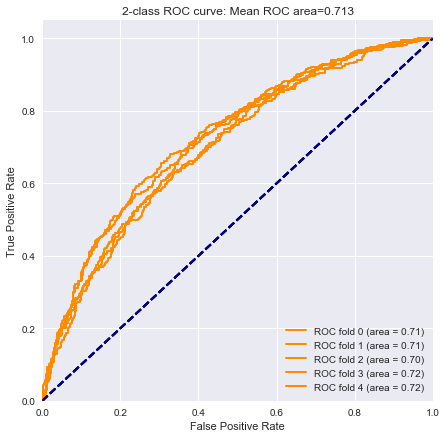

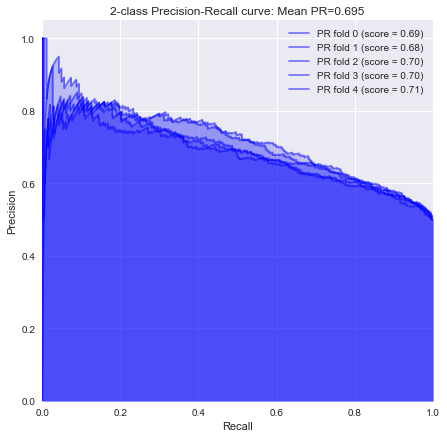

In [8]:
# градиентный бустинг:
gradBoost = ensemble.GradientBoostingClassifier()
y_scores, y_tests = KFold(gradBoost, x_data, y_data)
ROC(y_scores, y_tests)
PRC(y_scores, y_tests)

mean f1 score: 0.614308354969


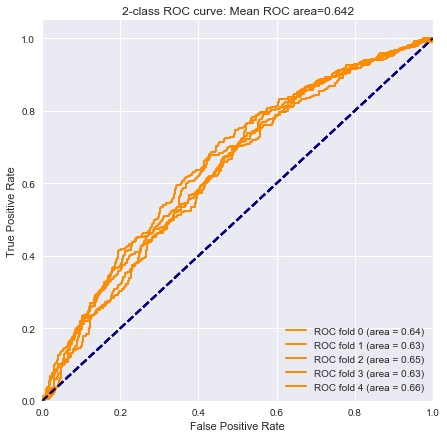

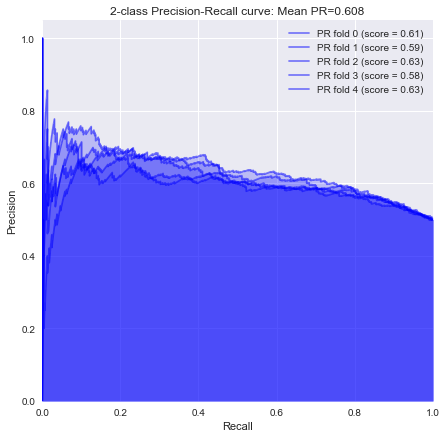

In [9]:
# Ridge:
ridge = linear_model.RidgeClassifier(random_state=2)
y_scores, y_tests = KFold(ridge, x_data, y_data)
ROC(y_scores, y_tests)
PRC(y_scores, y_tests)

mean f1 score: 0.567945658281


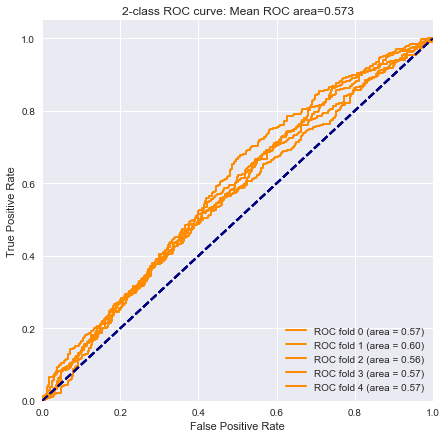

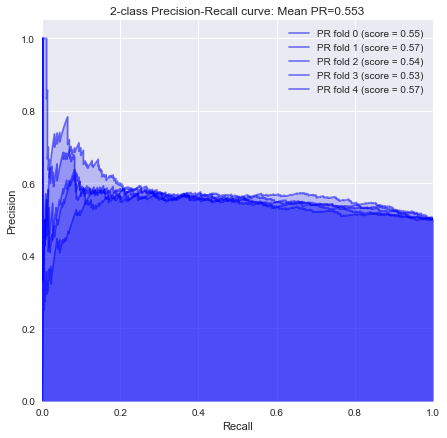

In [10]:
# LogisticRegression
logReg = linear_model.LogisticRegression()
y_scores, y_tests = KFold(logReg, x_data, y_data)
ROC(y_scores, y_tests)
PRC(y_scores, y_tests)

In [11]:
# RandomForest
# использую только f1-метрику, тк случайный лес не может предсказывать вероятности классов
RF = ensemble.RandomForestClassifier(n_estimators=100, max_depth=3)
print 'mean f1 score: '+ str(KFoldOnlyF1Score(RF, x_data, y_data))

mean f1 score: 0.646841048261


C:\ProgramData\Anaconda3\envs\py27\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


mean f1 score: 0.666666666667


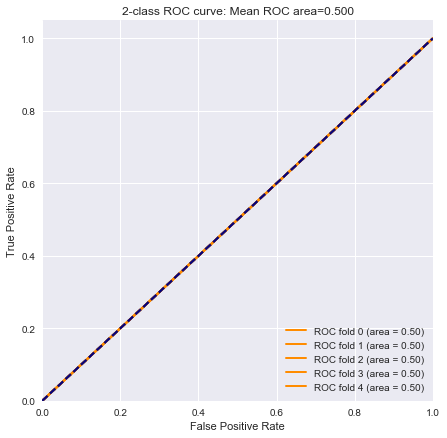

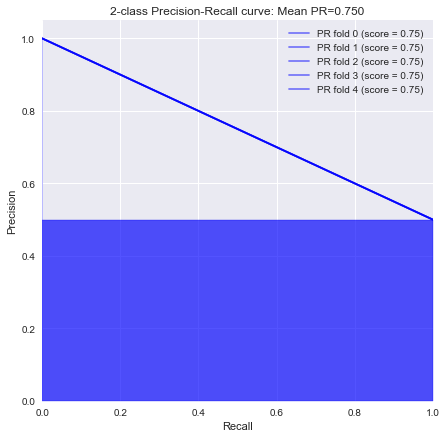

In [12]:
from sklearn.svm import SVC
clf = SVC(max_iter=10)
y_scores, y_tests = KFold(clf, x_data, y_data)
ROC(y_scores, y_tests)
PRC(y_scores, y_tests)
#судя по графикам svm не работает.

## 3. Вывод:

Из рассмотренных алгоритмов наиболее удачными являются градиентный бутинг и случайный лес. Возможно, стоит попробовать обучить XGBoost и оптимизировать параметры случайного леса